## Get all the necessary libraries: tensorflow, TFQ, Cirq, matplotlib and scipy

In [77]:
import tensorflow as tf
import tensorflow_quantum as tfq 

import cirq
import sympy
import numpy as np

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

from scipy.optimize import curve_fit
from scipy.stats import linregress

np.random.seed(1234)

# Functions split up to perform the necessary calculations for getting the sample variance of a random parameter quantum circuit

In [2]:
def calculate_batch_gradient_stats(circuits, symbol, op, nCircuits):
    """
        Construct a tape context, and watch the entire values_tensor (ie all circuit parameters)
        Calculate the gradient for this tape of operations, where we have a list of random circuits
        Then take the mean and variance of this list in the 0th axis,
        that is the first variable \theta_{1,1}
        
        Convert the circuit into a tensor and the sympy symbols into a tensor.
        Using the TensorFlow gradient tape
    """    
    numParameters = len(symbol)

    # Setup a simple layer to batch compute the expectation gradients.
    expectation = tfq.layers.Expectation()

    # Prep the inputs as tensors
    circuit_tensor = tfq.convert_to_tensor(circuits)
    values_tensor = tf.convert_to_tensor(
        np.random.uniform(0, 2 * np.pi, (nCircuits, numParameters)).astype(np.float32))
    
    # Use TensorFlow GradientTape to track gradients.
    with tf.GradientTape() as g:
        g.watch(values_tensor)
        forward = expectation(circuit_tensor,
                              operators=op,
                              symbol_names=symbol,
                              symbol_values=values_tensor)

    # Return variance of gradients across all circuits.
    grads = g.gradient(forward, values_tensor)
    grad_mean = tf.math.reduce_mean(grads, axis=0)
    grad_var = tf.math.reduce_std(grads, axis=0)
    
    return grad_mean.numpy()[0], grad_var.numpy()[1]


In [3]:
def generate_circuit_ansatz(qubits, symbol, depth):
    """
        Generate the circuit ansazt from McClean et al. given some symbol list
        The circuit starts with sqrt{H} on each wire, 
        then each layer is a randomly selected rotation on each wire and then a CNOT ladder
    """
    circuit = cirq.Circuit()
    for qubit in qubits:
        circuit += cirq.ry(np.pi / 4.0)(qubit)

    numQubits = len(qubits)
    
    for d in range(depth):
        # start with a random rotation gate on each qubit
        for i, qubit in enumerate(qubits):
            # pick a random number that selects which direction to rotate around 
            random_n = np.random.uniform()
            
            rot = symbol[d*numQubits + i]
            
            if random_n > 2. / 3.:
                # Add a Z.
                circuit += cirq.rz(rot)(qubit)
            elif random_n > 1. / 3.:
                # Add a Y.
                circuit += cirq.ry(rot)(qubit)
            else:
                # Add a X.
                circuit += cirq.rx(rot)(qubit)

        # Add CZ ladder.
        for src, dest in zip(qubits, qubits[1:]):
            circuit += cirq.CZ(src, dest)

    return circuit

In [4]:
def get_rpqc_stats(nQubits, depth, nCircuits):
    '''
        Get the Random Parameter Quantum Circuit and then send to gradient function
    '''
    # Generate the random circuits and observable for the given n.
    qubits = cirq.GridQubit.rect(1, nQubits)
    num_params = depth * nQubits
    symbol = sympy.symbols('vqe0:%d'%num_params) # The variational parameters
    #symbol = sympy.Symbol('theta')
    circuits = [
        generate_circuit_ansatz(qubits, symbol, depth) for _ in range(nCircuits)
    ]
    op = cirq.Z(qubits[0]) * cirq.Z(qubits[1])

    tmp = calculate_batch_gradient_stats(circuits, symbol, op, nCircuits)
    #theta_mean.append( tmp[0] )
    #theta_var.append( tmp[1] )
    
    return tmp[0], tmp[1]
    

In [133]:
def calcStatsForNQb(depth, n_qubits, n_circuits = 50):
    '''
        Wrapper function to calculate the statistics for RPQCs with a given number of qubits.
        Importantly, this function will be saving the variance/mean to .npy files since
        they take a while to run, and jupyter would sometimes fail during the larger runs.
    '''
    myMeans = np.zeros( len(n_qubits) )
    myVars = np.zeros( len(n_qubits) )

    print("depth of ", depth)
    filePath1 = "gradientMean_d=" + str(depth) + ".npy"
    filePath2 = "gradientVariance_d=" + str(depth) + ".npy"

    for i, nQubits in enumerate(n_qubits):
        print("number of qubits ", nQubits)
        mean, var = get_rpqc_stats(nQubits, depth, n_circuits)
        myMeans[i] = mean
        myVars[i] = var
        np.save(filePath1, myMeans)
        np.save(filePath2, myVars)
        print(myVars)
    return myMeans, myVars

# Set the number of qubits as a list from 4 to 18. Calculate the sample variance and mean of the two-Pauli term Hamiltonian for L layers, N qubits and n circuits to average over.

In [55]:
# 10, 25, 50, 75, 100, 150, 200, 300, 400, 500

n_qubits = [2 * i for i in range(2, 10)]

mean, var = calcStatsForNQb(250, n_qubits, n_circuits = 50)

print(var)

depth of  250
number of qubits  4
[0.16909942 0.         0.         0.         0.         0.
 0.         0.        ]
number of qubits  6
[0.16909942 0.05445281 0.         0.         0.         0.
 0.         0.        ]
number of qubits  8
[0.16909942 0.05445281 0.03612425 0.         0.         0.
 0.         0.        ]
number of qubits  10
[0.16909942 0.05445281 0.03612425 0.01671534 0.         0.
 0.         0.        ]
number of qubits  12
[0.16909942 0.05445281 0.03612425 0.01671534 0.00819051 0.
 0.         0.        ]
number of qubits  14
[0.16909942 0.05445281 0.03612425 0.01671534 0.00819051 0.004141
 0.         0.        ]
number of qubits  16
[0.16909942 0.05445281 0.03612425 0.01671534 0.00819051 0.004141
 0.0025871  0.        ]
number of qubits  18
[0.16909942 0.05445281 0.03612425 0.01671534 0.00819051 0.004141
 0.0025871  0.00103488]
[0.16909942 0.05445281 0.03612425 0.01671534 0.00819051 0.004141
 0.0025871  0.00103488]


# Plot the sample variance on a semi-log scale to demonstrate the expontial decay of the variance against number of qubits.

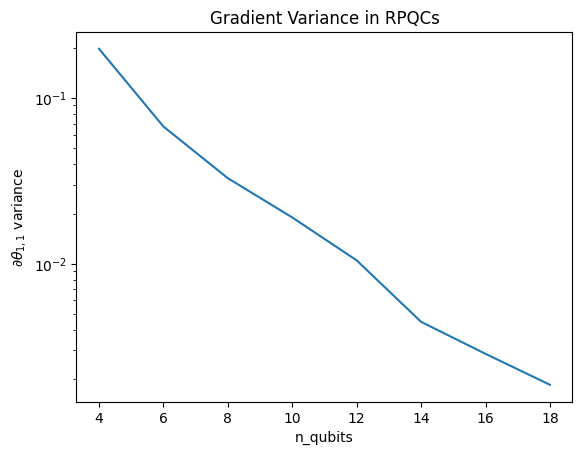

In [47]:
n_qubits = [2 * i for i in range(2, 10)]

#plt.semilogy(n_qubits, theta_var)
plt.semilogy(n_qubits, var)
plt.title('Gradient Variance in RPQCs')
plt.xlabel('n_qubits')
plt.xticks(n_qubits)
plt.ylabel('$\\partial \\theta_{1,1}$ variance')
plt.show()

In [134]:
# Load the gradient variance from file for L layers: 10, 50, 100, 150, 200, 250, 300, 400, 500
varsD10 = np.load("gradientVariance_d="+str(10)+".npy");
varsD50 = np.load("gradientVariance_d="+str(50)+".npy");
varsD100 = np.load("gradientVariance_d="+str(100)+".npy");
varsD150 = np.load("gradientVariance_d="+str(150)+".npy");
varsD200 = np.load("gradientVariance_d="+str(200)+".npy");
varsD250 = np.load("gradientVariance_d="+str(250)+".npy");
varsD300 = np.load("gradientVariance_d="+str(300)+".npy");
varsD400 = np.load("gradientVariance_d="+str(400)+".npy");
varsD500 = np.load("gradientVariance_d="+str(500)+".npy");

print(varsD10)

[0.15456228 0.16870658 0.18152431 0.17372067 0.16959937 0.18792625
 0.19767851 0.18639837]


In [135]:
# stack these numpy array to form one block array that can be indexed by number of layers or number of qubits
varsAll = np.stack( [varsD10, varsD50, varsD100, varsD150, varsD200, varsD250, varsD300, varsD400, varsD500], axis=0)

print(varsAll)

[[0.15456228 0.16870658 0.18152431 0.17372067 0.16959937 0.18792625
  0.19767851 0.18639837]
 [0.14060678 0.06645595 0.05606759 0.05528935 0.04416871 0.03595989
  0.03372151 0.0450061 ]
 [0.15774786 0.06621498 0.03924527 0.01678423 0.0142367  0.01039661
  0.01078582 0.00822058]
 [0.19779508 0.06715759 0.0327605  0.01899068 0.01046117 0.00445374
  0.00285585 0.00185736]
 [0.21622741 0.09155357 0.04309327 0.02153131 0.00864343 0.00465674
  0.00298946 0.00117702]
 [0.16909942 0.05445281 0.03612425 0.01671534 0.00819051 0.004141
  0.0025871  0.00103488]
 [0.20810893 0.06169949 0.0451221  0.01371784 0.01038058 0.00351966
  0.00167472 0.00102775]
 [0.13142158 0.08733461 0.05245753 0.01059683 0.01200875 0.00379868
  0.00247186 0.00110622]
 [0.08392408 0.06150743 0.03720506 0.01232948 0.01100518 0.00394186
  0.00172754 0.0014361 ]]


In [137]:
def fitExponentialCurve(y, x = [2 * i for i in range(2, 10)]):
    '''
        Exponential curve fitting using sciPy. I ended up not using this because a linear regression 
        fit after transforming the data by log scale was better and simplier
    '''
    def func(x, a, b):
        return a*np.power(2, -b*x)

    popt, pcov = curve_fit(func, x, y, p0=(1, 0.5))

    print(x)
    print(y)

    print(popt)
    print(pcov)

    print(np.sqrt(np.diag(pcov)))
    
    return popt, pcov

def fit2(y, x = [2 * i for i in range(2, 10)]):
    '''
        Second fit function I wrote that does a simple linear regression after log transformation
    '''
    def func(x, a, b):
        return a*x + b
    
    y = np.log(y)
    
    res = linregress(x, y)
    
    print(res.slope, " p\m ", res.stderr)
    
    return res

-0.3642287501068924  p\m  0.009954610183152


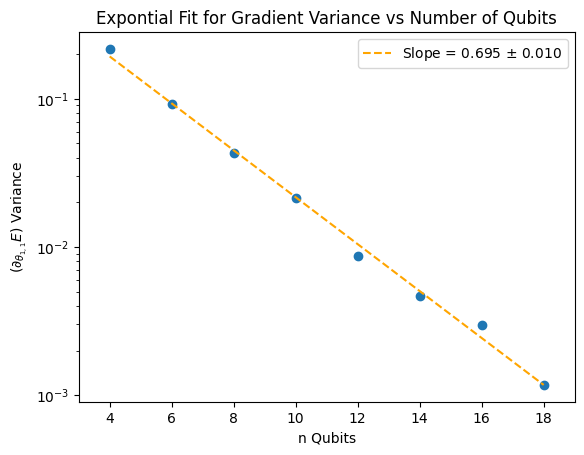

In [138]:
#popt, pcov = fitExponentialCurve(varsAll[6])

# plot data on log scale and include the line of best fit

yData = varsAll[4]

res = fit2(yData)

x = np.linspace(4, 18)
y = np.exp(res.slope*x+res.intercept )

# corrected slope
m = np.exp(res.slope)
deltaM = np.exp(res.stderr)*res.stderr

plt.plot(x, y, '--',c='orange', label=f"Slope = {m:.3f} $\pm$ {deltaM:.3f}")
plt.scatter(n_qubits, yData)
ax = plt.gca()
ax.set_yscale('log')

ax.set_xlim(3, 19)
ax.set_title("Expontial Fit for Gradient Variance vs Number of Qubits")
ax.set_ylabel(r"$(\partial_{\theta_{1,1}}E)$ Variance")
ax.set_xlabel("n Qubits")

plt.legend()

# Here I plot the sample variance versus number of qubits, with each line representing an ensemble of circuits with a different number of layers. On the top are the circuits with 10 layers, at the bottom the circuits with 500 layers.


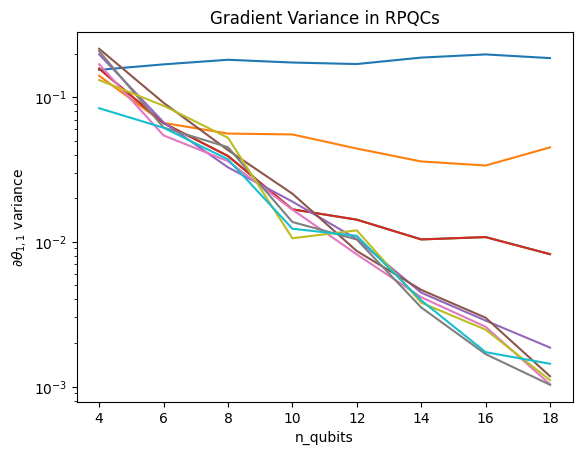

In [113]:
n_qubits = [2 * i for i in range(2, 10)]

plt.semilogy(n_qubits, varsAll[0])
plt.semilogy(n_qubits, varsAll[1])
plt.semilogy(n_qubits, varsAll[2])
plt.semilogy(n_qubits, varsAll[2])
plt.semilogy(n_qubits, varsAll[3])
plt.semilogy(n_qubits, varsAll[4])
plt.semilogy(n_qubits, varsAll[5])
plt.semilogy(n_qubits, varsAll[6])
plt.semilogy(n_qubits, varsAll[7])
plt.semilogy(n_qubits, varsAll[8])

plt.title('Gradient Variance in RPQCs')
plt.xlabel('n_qubits')
plt.xticks(n_qubits)
plt.ylabel('$\\partial \\theta_{1,1}$ variance')
plt.show()

# Here I plot the sample variance versus number of layers, with each line representing an ensemble of circuits with a different number of qubits. On the top are the circuits with 4 qubits, at the bottom the circuits with 18 qubits.


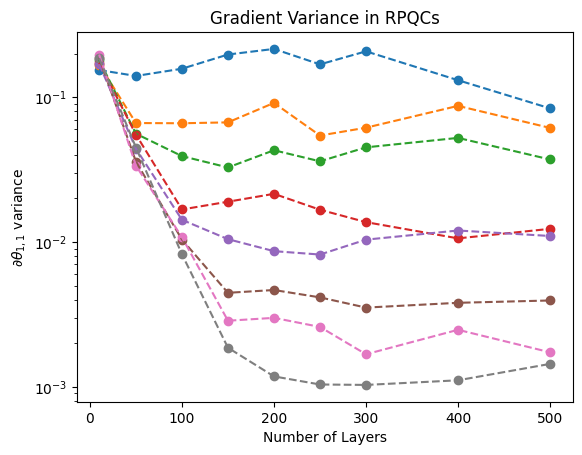

In [132]:
n_layers = [10, 50, 100, 150, 200, 250, 300, 400, 500]

plt.scatter(n_layers, varsAll[:,0])
plt.scatter(n_layers, varsAll[:,1])
plt.scatter(n_layers, varsAll[:,2])
plt.scatter(n_layers, varsAll[:,3])
plt.scatter(n_layers, varsAll[:,4])
plt.scatter(n_layers, varsAll[:,5])
plt.scatter(n_layers, varsAll[:,6])
plt.scatter(n_layers, varsAll[:,7])

plt.plot(n_layers, varsAll[:,0], '--')
plt.plot(n_layers, varsAll[:,1], '--')
plt.plot(n_layers, varsAll[:,2], '--')
plt.plot(n_layers, varsAll[:,3], '--')
plt.plot(n_layers, varsAll[:,4], '--')
plt.plot(n_layers, varsAll[:,5], '--')
plt.plot(n_layers, varsAll[:,6], '--')
plt.plot(n_layers, varsAll[:,7], '--')

ax = plt.gca()

ax.set_yscale('log')

plt.title('Gradient Variance in RPQCs')
plt.xlabel('Number of Layers')
#plt.xticks(n_layers)
plt.ylabel('$\\partial \\theta_{1,1}$ variance')
plt.show()